In [0]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from google.colab import drive

In [2]:
DIRECTORY = "/content/drive/My Drive/Colab Notebooks/Kaggle/data/"
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [0]:
pd.options.display.max_columns = 50

In [0]:
h = 28 
max_lags = 364 + 364 + 1
tr_last = 1913 - 28
fday = datetime(2016,4, 25) - timedelta(days=28) 
FIRST_DAY = 1 

params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.065,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 1200,
    'num_leaves': 112,
    "min_data_in_leaf": 100,
}

VERSION = "_customtest_RMSE_model6_model" 

In [0]:
def create_dt(is_train = True, nrows = None, first_day = 1200, tr_last=tr_last):
    prices = pd.read_csv(DIRECTORY + "data/sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv(DIRECTORY + "data/calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(DIRECTORY + "data/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [0]:
def create_fea(dt):
    lags = [7, 28, 364]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28, 364]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day"
    }
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [0]:
df = create_dt(is_train=True, first_day= FIRST_DAY)

In [9]:
create_fea(df)
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,lag_364,rmean7_7,rmean28_7,rmean364_7,rmean7_28,rmean28_28,rmean364_28,rmean7_364,rmean28_364,rmean364_364,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45174232,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1885,1.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,3.98,0.0,0.0,0.0,1.000000,0.428571,0.857143,1.178571,0.642857,0.892857,0.662088,0.631868,0.958791,12,1,27
45174233,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1884,2.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,0.0,0.0,1.428571,0.000000,0.000000,0.821429,1.000000,0.142857,0.980769,0.928571,0.423077,12,1,26
45174234,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1885,4.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,1.28,1.0,0.0,0.0,1.142857,0.000000,0.000000,0.857143,0.892857,0.142857,0.983516,0.928571,0.423077,12,1,27
45174235,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1884,0.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.00,1.0,4.0,1.0,2.142857,1.571429,1.571429,1.607143,1.607143,0.821429,1.760989,1.700549,1.640110,12,1,26


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45174237 entries, 0 to 45174236
Data columns (total 37 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  lag_7         float32       
 23  lag_28        float32       
 

In [11]:
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,lag_364,rmean7_7,rmean28_7,rmean364_7,rmean7_28,rmean28_28,rmean364_28,rmean7_364,rmean28_364,rmean364_364,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45174232,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1885,1.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,3.98,0.0,0.0,0.0,1.000000,0.428571,0.857143,1.178571,0.642857,0.892857,0.662088,0.631868,0.958791,12,1,27
45174233,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1884,2.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,0.0,0.0,1.428571,0.000000,0.000000,0.821429,1.000000,0.142857,0.980769,0.928571,0.423077,12,1,26
45174234,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1885,4.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,1.28,1.0,0.0,0.0,1.142857,0.000000,0.000000,0.857143,0.892857,0.142857,0.983516,0.928571,0.423077,12,1,27
45174235,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1884,0.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.00,1.0,4.0,1.0,2.142857,1.571429,1.571429,1.607143,1.607143,0.821429,1.760989,1.700549,1.640110,12,1,26


In [12]:
df.dropna(inplace = True)
df.shape

(23602466, 37)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23602466 entries, 12729751 to 45174236
Data columns (total 37 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  lag_7         float32       
 23  lag_28        float32  

In [14]:
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,lag_364,rmean7_7,rmean28_7,rmean364_7,rmean7_28,rmean28_28,rmean364_28,rmean7_364,rmean28_364,rmean364_364,week,quarter,mday
12729751,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_728,0.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,0.46,0.0,0.0,8.0,0.000000,0.000000,11.000000,0.000000,0.000000,9.607142,3.236264,3.763736,6.824176,4,1,25
12729758,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_728,0.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,1.77,1.0,1.0,3.0,1.857143,1.285714,0.714286,1.571429,1.750000,1.821429,1.667582,1.697802,1.821429,4,1,25
12729765,HOBBIES_1_010_CA_1_validation,9,0,0,0,0,d_728,1.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,2.97,0.0,0.0,1.0,0.714286,0.428571,1.000000,0.678571,0.750000,0.714286,0.895604,0.887363,0.543956,4,1,25
12729779,HOBBIES_1_012_CA_1_validation,11,0,0,0,0,d_728,0.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,6.52,0.0,2.0,0.0,0.714286,0.857143,0.285714,0.607143,0.535714,0.464286,0.420330,0.420330,0.552198,4,1,25
12729800,HOBBIES_1_015_CA_1_validation,14,0,0,0,0,d_728,0.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,0.72,1.0,1.0,0.0,3.000000,2.285714,7.714286,3.071429,3.928571,5.821429,5.203297,5.310440,6.722528,4,1,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45174232,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1885,1.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,3.98,0.0,0.0,0.0,1.000000,0.428571,0.857143,1.178571,0.642857,0.892857,0.662088,0.631868,0.958791,12,1,27
45174233,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1884,2.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,0.0,0.0,1.428571,0.000000,0.000000,0.821429,1.000000,0.142857,0.980769,0.928571,0.423077,12,1,26
45174234,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1885,4.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,1.28,1.0,0.0,0.0,1.142857,0.000000,0.000000,0.857143,0.892857,0.142857,0.983516,0.928571,0.423077,12,1,27
45174235,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1884,0.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.00,1.0,4.0,1.0,2.142857,1.571429,1.571429,1.607143,1.607143,0.821429,1.760989,1.700549,1.640110,12,1,26


In [0]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [0]:
np.random.seed(42)

fake_valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
                              categorical_feature=cat_feats,
                 free_raw_data=False)

In [17]:
del df, X_train, y_train, fake_valid_inds,train_inds ; gc.collect()

0

In [18]:
%%time
m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[20]	valid_0's rmse: 3.05144
[40]	valid_0's rmse: 2.6907
[60]	valid_0's rmse: 2.58329
[80]	valid_0's rmse: 2.54951
[100]	valid_0's rmse: 2.53593
[120]	valid_0's rmse: 2.52781
[140]	valid_0's rmse: 2.51788
[160]	valid_0's rmse: 2.5096
[180]	valid_0's rmse: 2.50054
[200]	valid_0's rmse: 2.49392
[220]	valid_0's rmse: 2.48495
[240]	valid_0's rmse: 2.4775
[260]	valid_0's rmse: 2.47026
[280]	valid_0's rmse: 2.46546
[300]	valid_0's rmse: 2.46029
[320]	valid_0's rmse: 2.45318
[340]	valid_0's rmse: 2.4473
[360]	valid_0's rmse: 2.44123
[380]	valid_0's rmse: 2.43545
[400]	valid_0's rmse: 2.4318
[420]	valid_0's rmse: 2.42811
[440]	valid_0's rmse: 2.42418
[460]	valid_0's rmse: 2.42062
[480]	valid_0's rmse: 2.41901
[500]	valid_0's rmse: 2.41637
[520]	valid_0's rmse: 2.41336
[540]	valid_0's rmse: 2.41049
[560]	valid_0's rmse: 2.4081
[580]	valid_0's rmse: 2.40536
[600]	valid_0's rmse: 2.40255
[620]	valid_0's rmse: 2.40009
[640]	valid_0's rmse: 2.3973
[660]	valid_0's rmse: 2.395
[680]	valid_0's rmse: 2

In [19]:
m_lgb.save_model(DIRECTORY + "models/modelv_" + str(VERSION) + ".lgb")

In [0]:
# #load model
# m_lgb = lgb.Booster(model_file=DIRECTORY + "models/modelv_" + str(VERSION) + ".lgb")

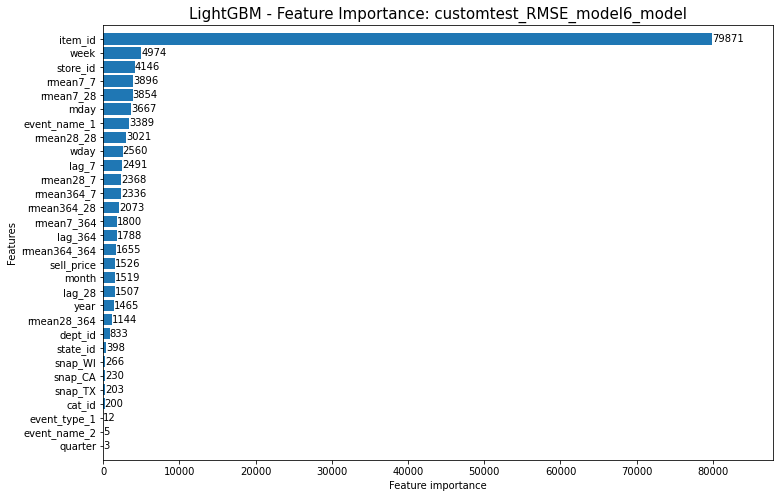

In [21]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18.0, 4)
%matplotlib inline
 
fig, ax = plt.subplots(figsize=(12,8))
lgb.plot_importance(m_lgb, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance: " + str(VERSION), fontsize=15)
plt.savefig(DIRECTORY + "models/modelv_" + str(VERSION) + ".png")

In [22]:
%%time

te = create_dt(False)
cols = [f"F{i}" for i in range(1,29)]

for tdelta in range(0, 28):
    day = fday + timedelta(days=tdelta)
    print(tdelta, day)
    tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
    create_fea(tst)
    tst = tst.loc[tst.date == day , train_cols]
    te.loc[te.date == day, "sales"] = m_lgb.predict(tst)

te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
te_sub.fillna(0., inplace = True)
te_sub.sort_values("id", inplace = True)
te_sub.reset_index(drop=True, inplace = True)
te_sub.to_csv(DIRECTORY + "submissions/submission_v" + str(VERSION) + ".csv",index=False)

0 2016-03-28 00:00:00
1 2016-03-29 00:00:00
2 2016-03-30 00:00:00
3 2016-03-31 00:00:00
4 2016-04-01 00:00:00
5 2016-04-02 00:00:00
6 2016-04-03 00:00:00
7 2016-04-04 00:00:00
8 2016-04-05 00:00:00
9 2016-04-06 00:00:00
10 2016-04-07 00:00:00
11 2016-04-08 00:00:00
12 2016-04-09 00:00:00
13 2016-04-10 00:00:00
14 2016-04-11 00:00:00
15 2016-04-12 00:00:00
16 2016-04-13 00:00:00
17 2016-04-14 00:00:00
18 2016-04-15 00:00:00
19 2016-04-16 00:00:00
20 2016-04-17 00:00:00
21 2016-04-18 00:00:00
22 2016-04-19 00:00:00
23 2016-04-20 00:00:00
24 2016-04-21 00:00:00
25 2016-04-22 00:00:00
26 2016-04-23 00:00:00
27 2016-04-24 00:00:00
CPU times: user 2h 27min 1s, sys: 2min 13s, total: 2h 29min 15s
Wall time: 2h 24min 40s


In [23]:
te_sub

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.703675,0.747119,0.698478,0.673117,0.977465,1.005034,0.906115,0.683687,0.674423,0.682257,0.693541,0.824382,0.991275,0.964454,0.720954,0.701071,0.707098,0.739241,0.837142,0.990354,0.955323,0.654321,0.675109,0.676401,0.661958,0.797455,0.967099,1.007250
1,FOODS_1_001_CA_2_validation,1.153105,1.018925,0.852435,0.888980,1.182632,1.377427,1.252118,0.888694,0.907165,0.936009,0.965488,1.137966,1.374443,1.280435,0.909689,0.872847,0.885258,0.884261,1.077884,1.282935,1.219386,0.787860,0.744288,0.757628,0.800977,0.994085,1.319062,1.338431
2,FOODS_1_001_CA_3_validation,1.377275,1.284176,1.024650,1.054729,1.157291,1.924041,1.431916,1.135924,1.255986,1.136500,1.133349,1.311158,1.631756,1.462556,1.217838,1.222703,1.081910,1.101726,1.315935,1.570864,1.507761,1.147333,1.102309,1.018596,1.035053,1.201631,1.444385,1.579161
3,FOODS_1_001_CA_4_validation,0.526523,0.508077,0.479817,0.466005,0.405098,0.478736,0.422423,0.396315,0.381594,0.409582,0.409893,0.426522,0.487866,0.460069,0.343817,0.337724,0.341024,0.348663,0.378979,0.445776,0.401127,0.342737,0.337901,0.345027,0.364578,0.398775,0.474403,0.464895
4,FOODS_1_001_TX_1_validation,0.548880,0.492466,0.493772,0.457338,0.931959,0.692025,0.624487,0.499578,0.513402,0.530919,0.539354,0.593877,0.762766,0.640538,0.519479,0.511178,0.540732,0.508135,0.615105,0.740041,0.657225,0.511243,0.471242,0.481450,0.469218,0.585682,0.716366,0.678064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.304269,0.292484,0.281510,0.312335,0.331255,0.385552,0.376276,0.293842,0.281820,0.283484,0.297052,0.329172,0.385763,0.398153,0.312338,0.295012,0.283396,0.293366,0.325616,0.426586,0.418160,0.321061,0.304150,0.293477,0.293948,0.339220,0.412184,0.414632
30486,HOUSEHOLD_2_516_TX_3_validation,0.174294,0.175128,0.168415,0.185157,0.193970,0.243303,0.246048,0.184493,0.174873,0.196405,0.185632,0.202964,0.239657,0.225083,0.183247,0.183136,0.178699,0.179751,0.200156,0.248557,0.231910,0.176554,0.175233,0.174474,0.179053,0.189773,0.231316,0.224347
30487,HOUSEHOLD_2_516_WI_1_validation,0.099324,0.095149,0.102494,0.102030,0.118866,0.122054,0.116532,0.093384,0.090713,0.089909,0.094581,0.119347,0.141426,0.131203,0.092417,0.089960,0.090390,0.093792,0.116488,0.138160,0.143997,0.106321,0.096875,0.097017,0.101081,0.125339,0.137070,0.135214
30488,HOUSEHOLD_2_516_WI_2_validation,0.083067,0.083321,0.089918,0.093692,0.102153,0.109405,0.104935,0.092120,0.091225,0.090581,0.094692,0.113762,0.127986,0.120200,0.086665,0.087634,0.086308,0.089402,0.105891,0.121288,0.115802,0.087898,0.088719,0.088156,0.089808,0.105392,0.120151,0.115667


In [0]:
te_sub2 = te_sub.copy()
te_sub2["id"] = te_sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([te_sub, te_sub2], axis =0, sort=False)
sub.to_csv(DIRECTORY + "submissions/submission_v" + str(VERSION) + "kaggle.csv",index=False)

In [0]:

def create_test():
  """
  Create test set starting from last day + 1 used for
  trainining. We split our trining data into test and train,
  we use the last 28 days as test set, and all the previous
  as train set. Last day of train data is 1913 - 28,
  first day of test is 1913 - 28 + 1 )
  """
  df_test2 = create_dt(is_train=True, first_day= 1913-27, tr_last=1913)
  cols = [f"F{i}" for i in range(1,29)]
  df_test2["F"] = [f"F{rank}" for rank in df_test2.groupby("id")["id"].cumcount()+1]
  df_test2 = df_test2.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
  df_test2.fillna(0., inplace = True)
  df_test2.sort_values("id", inplace = True)
  df_test2.reset_index(drop=True, inplace = True)
  return df_test2

def is_testset_correct(test_set):
  """
  Run only if check is needed, memory consumption.
  Given a test_set (in submission format) we created,
  we check if it actually match the last 28 days of
  the true sales train validation data.
  Return 0 if perfect match.
  """
  true_sales = pd.read_csv(DIRECTORY + "data/sales_train_validation.csv")
  dcols = [f"d_{i}" for i in range(1913-27, 1914)]
  fcols = [f"F{i}" for i in range(1, 29)]
  true_sales = true_sales[["id"] + dcols]
  true_sales.sort_values("id", inplace = True)

  test_set = test_set[["id"] + fcols]
  value = np.sum(test_set[fcols].values - true_sales[dcols].values)
  return value

def get_rmse(predictions):
  """
  Given a prediction (submission format),
  return RMSE using the create_test function
  (last 28 days of the sales_train_validation.csv
  in submission format)
  """
  test_data = create_test().iloc[:,1:]
  predictions = predictions.iloc[:,1:]
  error = mean_squared_error(predictions, test_data, squared=False)
  return error


In [51]:
x2

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.703675,0.747119,0.698478,0.673117,0.977465,1.005034,0.906115,0.683687,0.674423,0.682257,0.693541,0.824382,0.991275,0.964454,0.720954,0.701071,0.707098,0.739241,0.837142,0.990354,0.955323,0.654321,0.675109,0.676401,0.661958,0.797455,0.967099,1.007250
1,FOODS_1_001_CA_2_validation,1.153105,1.018925,0.852435,0.888980,1.182632,1.377427,1.252118,0.888694,0.907165,0.936009,0.965488,1.137966,1.374443,1.280435,0.909689,0.872847,0.885258,0.884261,1.077884,1.282935,1.219386,0.787860,0.744288,0.757628,0.800977,0.994085,1.319062,1.338431
2,FOODS_1_001_CA_3_validation,1.377275,1.284176,1.024650,1.054729,1.157291,1.924041,1.431916,1.135924,1.255986,1.136500,1.133349,1.311158,1.631756,1.462556,1.217838,1.222703,1.081910,1.101726,1.315935,1.570864,1.507761,1.147333,1.102309,1.018596,1.035053,1.201631,1.444385,1.579161
3,FOODS_1_001_CA_4_validation,0.526523,0.508077,0.479817,0.466005,0.405098,0.478736,0.422423,0.396315,0.381594,0.409582,0.409893,0.426522,0.487866,0.460069,0.343817,0.337724,0.341024,0.348663,0.378979,0.445776,0.401127,0.342737,0.337901,0.345027,0.364578,0.398775,0.474403,0.464895
4,FOODS_1_001_TX_1_validation,0.548880,0.492466,0.493772,0.457338,0.931959,0.692025,0.624487,0.499578,0.513402,0.530919,0.539354,0.593877,0.762766,0.640538,0.519479,0.511178,0.540732,0.508135,0.615105,0.740041,0.657225,0.511243,0.471242,0.481450,0.469218,0.585682,0.716366,0.678064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.304269,0.292484,0.281510,0.312335,0.331255,0.385552,0.376276,0.293842,0.281820,0.283484,0.297052,0.329172,0.385763,0.398153,0.312338,0.295012,0.283396,0.293366,0.325616,0.426586,0.418160,0.321061,0.304150,0.293477,0.293948,0.339220,0.412184,0.414632
30486,HOUSEHOLD_2_516_TX_3_validation,0.174294,0.175128,0.168415,0.185157,0.193970,0.243303,0.246048,0.184493,0.174873,0.196405,0.185632,0.202964,0.239657,0.225083,0.183247,0.183136,0.178699,0.179751,0.200156,0.248557,0.231910,0.176554,0.175233,0.174474,0.179053,0.189773,0.231316,0.224347
30487,HOUSEHOLD_2_516_WI_1_validation,0.099324,0.095149,0.102494,0.102030,0.118866,0.122054,0.116532,0.093384,0.090713,0.089909,0.094581,0.119347,0.141426,0.131203,0.092417,0.089960,0.090390,0.093792,0.116488,0.138160,0.143997,0.106321,0.096875,0.097017,0.101081,0.125339,0.137070,0.135214
30488,HOUSEHOLD_2_516_WI_2_validation,0.083067,0.083321,0.089918,0.093692,0.102153,0.109405,0.104935,0.092120,0.091225,0.090581,0.094692,0.113762,0.127986,0.120200,0.086665,0.087634,0.086308,0.089402,0.105891,0.121288,0.115802,0.087898,0.088719,0.088156,0.089808,0.105392,0.120151,0.115667


In [55]:
x2[:30490]

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.703675,0.747119,0.698478,0.673117,0.977465,1.005034,0.906115,0.683687,0.674423,0.682257,0.693541,0.824382,0.991275,0.964454,0.720954,0.701071,0.707098,0.739241,0.837142,0.990354,0.955323,0.654321,0.675109,0.676401,0.661958,0.797455,0.967099,1.007250
1,FOODS_1_001_CA_2_validation,1.153105,1.018925,0.852435,0.888980,1.182632,1.377427,1.252118,0.888694,0.907165,0.936009,0.965488,1.137966,1.374443,1.280435,0.909689,0.872847,0.885258,0.884261,1.077884,1.282935,1.219386,0.787860,0.744288,0.757628,0.800977,0.994085,1.319062,1.338431
2,FOODS_1_001_CA_3_validation,1.377275,1.284176,1.024650,1.054729,1.157291,1.924041,1.431916,1.135924,1.255986,1.136500,1.133349,1.311158,1.631756,1.462556,1.217838,1.222703,1.081910,1.101726,1.315935,1.570864,1.507761,1.147333,1.102309,1.018596,1.035053,1.201631,1.444385,1.579161
3,FOODS_1_001_CA_4_validation,0.526523,0.508077,0.479817,0.466005,0.405098,0.478736,0.422423,0.396315,0.381594,0.409582,0.409893,0.426522,0.487866,0.460069,0.343817,0.337724,0.341024,0.348663,0.378979,0.445776,0.401127,0.342737,0.337901,0.345027,0.364578,0.398775,0.474403,0.464895
4,FOODS_1_001_TX_1_validation,0.548880,0.492466,0.493772,0.457338,0.931959,0.692025,0.624487,0.499578,0.513402,0.530919,0.539354,0.593877,0.762766,0.640538,0.519479,0.511178,0.540732,0.508135,0.615105,0.740041,0.657225,0.511243,0.471242,0.481450,0.469218,0.585682,0.716366,0.678064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.304269,0.292484,0.281510,0.312335,0.331255,0.385552,0.376276,0.293842,0.281820,0.283484,0.297052,0.329172,0.385763,0.398153,0.312338,0.295012,0.283396,0.293366,0.325616,0.426586,0.418160,0.321061,0.304150,0.293477,0.293948,0.339220,0.412184,0.414632
30486,HOUSEHOLD_2_516_TX_3_validation,0.174294,0.175128,0.168415,0.185157,0.193970,0.243303,0.246048,0.184493,0.174873,0.196405,0.185632,0.202964,0.239657,0.225083,0.183247,0.183136,0.178699,0.179751,0.200156,0.248557,0.231910,0.176554,0.175233,0.174474,0.179053,0.189773,0.231316,0.224347
30487,HOUSEHOLD_2_516_WI_1_validation,0.099324,0.095149,0.102494,0.102030,0.118866,0.122054,0.116532,0.093384,0.090713,0.089909,0.094581,0.119347,0.141426,0.131203,0.092417,0.089960,0.090390,0.093792,0.116488,0.138160,0.143997,0.106321,0.096875,0.097017,0.101081,0.125339,0.137070,0.135214
30488,HOUSEHOLD_2_516_WI_2_validation,0.083067,0.083321,0.089918,0.093692,0.102153,0.109405,0.104935,0.092120,0.091225,0.090581,0.094692,0.113762,0.127986,0.120200,0.086665,0.087634,0.086308,0.089402,0.105891,0.121288,0.115802,0.087898,0.088719,0.088156,0.089808,0.105392,0.120151,0.115667


In [57]:
filename = DIRECTORY + "submissions/submission_v" + str(VERSION)
threshold = 0.65
x = pd.read_csv(filename + ".csv")
x2 = pd.read_csv(filename + ".csv")

import math
for col in x.iloc[:,1:]:
  entries = x[col]
  print(col)

  for i, entry in enumerate(x[col]):
    fractional = math.modf(entry)[0]
    integer = math.modf(entry)[1]
    if fractional > threshold:
      x[col].iloc[i] = integer + 1

x.to_csv(filename + "RoundUP_" + str(threshold) + ".csv",index=False)

F1


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


F2
F3
F4
F5
F6
F7
F8
F9
F10
F11
F12
F13
F14
F15
F16
F17
F18
F19
F20
F21
F22
F23
F24
F25
F26
F27
F28


In [58]:
print("Original")
print(get_rmse(x2[:30490]))

print("Rounded up " + str(threshold))
print(get_rmse(x[:30490]))

Original
2.056849731593805
Rounded up 0.65
2.0605327840742116
